# LSTM for Multivariate Time Series

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from typing import Union
import matplotlib.pyplot as plt

## Load Data

We explore the Tesla stock data in our demonstration.

In [2]:
stocks: pd.DataFrame = pd.read_csv("../../data/stocks.csv", index_col=0, parse_dates=True)
company = "TSLA"
stock = stocks.query(f"Company == '{company}'").drop(columns=["Company", "Sector"])
stock

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-02,20.008667,20.579332,19.508667,19.950666,296871000
2017-11-03,19.966667,20.416668,19.675333,20.406000,133410000
2017-11-06,20.466667,20.500000,19.934000,20.185333,97290000
2017-11-07,20.068001,20.433332,20.002001,20.403334,79414500
2017-11-08,20.366667,20.459333,20.086666,20.292667,70879500
...,...,...,...,...,...
2022-10-26,219.399994,230.600006,218.199997,224.639999,85012500
2022-10-27,229.770004,233.809998,222.850006,225.089996,61638800
2022-10-28,225.399994,228.860001,216.350006,228.520004,69152400


Leave out the last 90 days for testing:

In [3]:
num_days = 90
train_df = stock[:-num_days]
test_df = stock[-num_days:]

## Encode Column Names in the Data Frame

Since the input of PyTorch and Scikit-learn's model is usually a NumPy array of a tensor, we need to extract the data from Pandas' data frame by dropping the information of column names and indices, etc. 

But we also need the connection between the raw data and its actual meaning. For example, we need to know the original column name of a column vector in the array. Scikit-learn's `LabelEncoder` can help us with this.

In [4]:
from sklearn.preprocessing import LabelEncoder

ALL_FEATURES = stock.columns.tolist()
feature_encoder = LabelEncoder()
feature_encoder.fit(ALL_FEATURES)

feature_encoder.classes_

array(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='<U6')

```{note}
Note that the *order* of column names in `feature_encoder.class_` does not be the same as that in the original data frame!
```

Now, we transform the data frame to a NumPy array, which is in fact a time series (hence the name `train_ts`).

In [5]:
# re-order the columns by the column names in the feature encoder
# and then convert it to NumPy array
train_ts = train_df[feature_encoder.classes_].to_numpy()
train_ts

array([[1.99506664e+01, 2.05793324e+01, 1.95086670e+01, 2.00086670e+01,
        2.96871000e+08],
       [2.04060001e+01, 2.04166679e+01, 1.96753330e+01, 1.99666672e+01,
        1.33410000e+08],
       [2.01853333e+01, 2.05000000e+01, 1.99340000e+01, 2.04666672e+01,
        9.72900000e+07],
       ...,
       [2.36086670e+02, 2.46833328e+02, 2.33826660e+02, 2.34503326e+02,
        1.01107500e+08],
       [2.35070007e+02, 2.39316666e+02, 2.28636673e+02, 2.37906662e+02,
        1.04202600e+08],
       [2.45706665e+02, 2.46066666e+02, 2.36086670e+02, 2.37470001e+02,
        9.57708000e+07]])

Now, if we want to know what is the meaning of the first column if `train_ts`, we can use the following code:

In [6]:
# index 0 means the first column
feature_encoder.inverse_transform([0])

array(['Close'], dtype='<U6')

Hence, the first column stores the closing prices.

## Sliding Windows

Basically, in our LSTM model, we need to use $M$ days' data to predict the closing prices of the next $N$ days. Hence, we need to slide a window (with size $M + N$) across the time series data (imagine a single-variate time series for now), and then *stack* all the windows together into a large matrix.

The following figure illustrates this idea.

<img src="../figures/sliding-window.png"/>

In [7]:

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler

class TimeSeriesTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(
            self,
            feature_encoder: LabelEncoder,
            features: list[str] = ["Close"],
            seq_len: int = 10,
            pred_len: int = 1,
        ) -> None:
        """A transformer that transform the time series
        to the format suitable for LSTM model.
        """
        
        super().__init__()
        
        self.feature_encoder = feature_encoder
        self.features = features
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
    
    def fit(
            self, 
            ts: np.ndarray,
            split_X_y: bool = True
        ):
        
        # make sure "Close" is at the end of features
        if "Close" in self.features:
            self.features.remove("Close")
        self.features.append("Close")
        
        # select features of interest
        ts = ts[:, self.feature_encoder.transform(self.features)]
        
        # fit min-max scaler to the data
        self.scaler.fit(ts)
        
        return self
    
    def transform(
            self, 
            ts: np.ndarray,
            split_X_y: bool = True
        ) -> tuple[np.ndarray, np.ndarray]:
        
        # select features of interest
        ts = ts[:, self.feature_encoder.transform(self.features)]

        # scale the values of the time series
        scaled_ts = self.scaler.transform(ts)
        
        # convert to the format suitable for LSTM
        window_size = self.seq_len + self.pred_len if split_X_y else self.seq_len
        X_y = np.array([
            scaled_ts[i : i + window_size]
            for i in range(len(scaled_ts) - window_size + 1)
        ])
        
        if split_X_y:
            
            X = X_y[:, :-self.pred_len, :]
            y = X_y[:, -self.pred_len:, -1]
            
            return X, y
        
        else:
            
            X = X_y
            return X

## Build LSTM Model

We use the framework of PyTorch to build an LSTM model for multivariate time series:

In [8]:
class LSTM(nn.Module):
    
    def __init__(
            self,
            input_size: int, 
            hidden_size: int,
            num_layers: int, 
            output_size: int
        ) -> None:
        
        # initialize super class
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        # LSTM layer
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)

        # fully connected layer
        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Notes:
        ------
        - `output` has shape (N, L, H)
        - `h_n` has shape (`num_layers`, N, H)
        
        where 
        - N is the batch size,
        - L is the sequence length, and
        - H is the hidden size
        """
        
        output, (h_n, c_n) = self.lstm.forward(x)

        # in fact, we want the last hidden value
        # from the last LSTM layer, i.e., h_n[-1, :, :]
        h = h_n[-1, :, :]

        # get predicted value from
        # the fully connected layer
        y = self.fc.forward(h)

        return y

We have also implemented a function to train the LSTM:

In [9]:
def _train(
        model: LSTM, 
        X_train: np.ndarray, 
        y_train: np.ndarray,
        num_epochs: int = 10,
        lr: float = 0.01,
        quiet=True
    ) -> float:
    
    # convert to tensors
    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train)
    
    # loss function
    criterion = nn.MSELoss(reduction="mean")
    
    # optimizer
    optimiser = optim.Adam(model.parameters(), lr=lr)
    
    for i in range(num_epochs):
        
        # predicted value
        y_pred = model.forward(X_train)

        # calculate loss
        loss: torch.Tensor = criterion(y_pred, y_train)
        
        if not quiet:
            print(f"epoch:\t{i}\tloss:\t{loss}")

        # clear gradients
        optimiser.zero_grad()

        # compute gradients through backward propagation
        loss.backward()

        # update parameters
        optimiser.step()

```{note}
Note that we put an underscore in the front of this funciton to indicate that it is a private function of this module. We don't expect users to use this function directly, since in fact we will wrap another class `PricePredictor` over this LSTM model.
```

## Price Predictor

Note that there are a lot of *hyperparameters* to be determined for the LSTM. The idea is that we want to keep the inner central LSTM model as simple as possible. So, we define another class `PricePredictor` that wraps in the LSTM, and at the same time, provides all possible hyperparameters and other methods like `fit` and `predict` that will be exposed to the users.

In [10]:
from sklearn.metrics import r2_score, mean_squared_error

class PricePredictor(BaseEstimator):
    
    feature_encoder: LabelEncoder = None
    
    def __init__(
            self,
            features: list[str] = ["Close"],
            seq_len: int = 10,
            pred_len: int = 1,
            num_days_ago: int = 100,
            hidden_size: int = 32,
            num_layers: int = 1,
            num_epochs: int = 50,
            lr: float = 0.01   
        ) -> None:
        """A model that takes in M days to predict N-day closing prices 
        where M is `seq_len` and N is `pred_len`.

        Parameters
        ----------
            features (list[str], optional): Features of interest. Defaults to ["Close"].
            seq_len (int, optional): The number of days needed to predict prices. Defaults to 10.
            pred_len (int, optional): The number of days of closing prices to predict. Defaults to 1.
            num_days_ago (int, optional): The latest few days of the provided trainig date to consider. Defaults to 100.
            hidden_size (int, optional): Hidden size of LSTM. Defaults to 32.
            num_layers (int, optional): Number of layers of LSTM. Defaults to 1.
            num_epochs (int, optional): Number of epochs to train. Defaults to 10.
            lr (float, optional): Learning rate. Defaults to 0.01.

        Raises
        ------
            Exception: Missing feature encoder.
        """
        
        super().__init__()
        
        # initialize feature encoder
        if PricePredictor.feature_encoder is None:
            raise Exception("Feature encoder must be proveded as a class attribute.")
        
        self.features = features
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_days_ago = num_days_ago
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_epochs = num_epochs
        self.lr = lr
        
        # underlying LSTM model
        self.model: LSTM = None
        
        # time series transformer
        self.ts_transformer: TimeSeriesTransformer = None
        
        # the last sequence of input time series with length `self.seq_len`
        self.last_seq: np.ndarray = None
        
        # metric / method of scoring
        self.metric: str = "R2"
        
        # R2 score
        self.rs: float = None
        
        # mean squared error
        self.mse: float = None
        
    def _get_input_size(self) -> int:
        """Find the input size for the LSTM model.

        Returns
        -------
            int: Input size.
        """
        
        input_size = len(self.features)
        if "Close" not in self.features:
            input_size += 1
        return input_size
    
    def fit(self, ts: np.ndarray, quiet=True):
        """Fit the model.

        Parameters
        ----------
            ts (np.ndarray): Training time series.
            quiet (bool, optional): If `quiet` is `False` then training losses will be printed in the terminal. 
            Defaults to True.
        """
        
        # initialize LSTM model
        self.model = LSTM(
            input_size=self._get_input_size(),
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            output_size=self.pred_len
        )
        
        # initialize time series transformer
        self.ts_transformer = TimeSeriesTransformer(
            feature_encoder=self.feature_encoder,
            features=self.features,
            seq_len=self.seq_len,
            pred_len=self.pred_len
        )
        
        # only keep the last few days
        ts = ts[-self.num_days_ago:]
        
        # store the last sequence of the time series for prediction
        self.last_seq = ts[-self.seq_len:].copy()
        
        # get X and y
        X, y = self.ts_transformer.fit_transform(ts)
        
        # train LSTM model
        _train(
            model=self.model,
            X_train=X,
            y_train=y,
            num_epochs=self.num_epochs,
            lr=self.lr,
            quiet=quiet
        )
    
    def score(self, test_ts: np.ndarray) -> float:
        """Compute the fitting score.

        Parameters
        ----------
            test_ts (np.ndarray): Test time seires.

        Returns
        -------
            float:
            
                1. R2 score is returned by default.
                2. If the computation of R2 score fails, then the negative MSE is returned.
        """
        
        # get true prices
        test_ts = test_ts[:self.pred_len]
        test_ts = test_ts[:, self.feature_encoder.transform(["Close"])]
        y_true = test_ts.flatten()

        # predicted prices
        y_pred = self.predict()
        
        # mean squred error
        self.mse = mean_squared_error(y_true, y_pred)
        
        if len(y_pred) >= 2:
            self.r2 = r2_score(y_true, y_pred)
            return self.r2
        else:
            self.metric = "Negative MSE"
            return -self.mse
    
    def predict(
            self, 
            ts: Union[np.ndarray, None] = None
        ) -> np.ndarray:
        """Predict the prices of future N days if no input is provided
        where n equals the attribute `pred_len`. 
        If a time series (M days) is passed to this function, 
        then each time the function will take one of M days 
        to predict the prices of the next N days. 
        So, there will be (M + 1) batches of N-day prices.

        Parameters
        ----------
            ts (Union[np.ndarray, None], optional): A time series consisting of future data. 
            Defaults to None.

        Returns
        -------
            np.ndarray: 
            
                1. If the input is `None`, then a 1-D NumPy array of future N-day prices is returned.
                2. If there is an input time series, then an (M + 1)-by-N NumPy array is returned.
        """
        
        # a flag indicating whether there is an input time series
        is_empty_input = ts is None
        
        if is_empty_input:
            ts = self.last_seq
        else:
            # attach the input time series
            # to the last sequence of data
            ts = np.concatenate((self.last_seq, ts))
        
        # transform the time series
        X = self.ts_transformer.transform(ts, split_X_y=False)
        
        # convert to tensor
        X = torch.Tensor(X).detach()
              
        # predit with LSTM model
        y_pred: torch.Tensor = self.model.forward(X)

        # convert to NumPy array
        y_pred = y_pred.detach().numpy()
        
        # rescale the predicted values to prices
        sliding_prices: np.ndarray = np.apply_along_axis(
            self._to_price, 
            axis=1, 
            arr=y_pred
        )
        
        if is_empty_input:
            # return a 1-D array of future N-day prices
            price = sliding_prices[0]
            return price
        
        else:
            # return (M + 1) baches of N-day prices
            return sliding_prices
    
    def _to_price(self, y_pred: np.ndarray) -> np.ndarray:
        """Recover the price from the scaled data.

        Parameters
        ----------
            y_pred (np.ndarray): Predicted values ranging from -1 to 1.

        Returns
        -------
            np.ndarray: Prices.
        """
        
        price_min = self.ts_transformer.scaler.data_min_[-1]
        price_range = self.ts_transformer.scaler.data_range_[-1]
        feature_min, feature_max = self.ts_transformer.scaler.feature_range
        price = price_min + (y_pred - feature_min) * price_range / (feature_max - feature_min)
        return price

## Fine-Tune the Model: Randomized Search

The common methods of tuning the hyperparameters are grid search and randomized search. For grid search, we will need to fit a model for every combination of possible parameters, which is extremely time-consuming. In practice, it is pref red to use randomized search.

In out project, we intend use Scikit-learn's `RandomizedSearchCV` to do the randomized search. As described in the official documentation, our estimator / model needs to implement `fit` and `score` methods, which we have already done this in the previous section.

We define a function `train` that implements the randomized search to train our model:

In [11]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

def train(
        stocks: pd.DataFrame,
        company: str,
        num_days_left_out: int = 90,
        pred_len: int = 1
    ) -> dict:
    
    feature_encoder = LabelEncoder()
    feature_encoder.fit(ALL_FEATURES)
    df = stocks.query(f"Company == '{company}'")
    train_df = df[:-num_days_left_out]
    train_df = train_df[ALL_FEATURES]
    train_ts = train_df[feature_encoder.classes_].to_numpy()
    
    # a sliding window splitter for time series cross validation
    ts_cv = TimeSeriesSplit(
        n_splits=2,
        test_size=pred_len
    )
    
    # initialize a price predictor model
    PricePredictor.feature_encoder = feature_encoder
    price_predictor = PricePredictor(pred_len=pred_len)
    
    # use random search to tune the model
    search = RandomizedSearchCV(
        price_predictor,
        {
            "features": [
                ["Close"],
                ["Close", "Open"],
                ["Close", "Open", "Volume"]
            ],
            "seq_len": [
                30, 60, 90
            ],
            "num_days_ago": [
                300, 400, 500
            ],
            "hidden_size": [
                16, 32
            ],
            "num_layers": [
                1, 2
            ]
        },
        cv=ts_cv,
        n_iter=10,
        verbose=2
    )
    
    # train!
    search.fit(train_ts)
    
    # return the training result
    train_result = {
        "model": search.best_estimator_,
        "params": search.best_params_,
        "score": search.best_score_
    }
    
    return train_result

Finally, we are ready to train the model:

```{note}
The following cell is not executable since we discover that something may go wrong when one execute this notebook online. Therefore, we display execution output from our machine in the following.
```

```py
stocks: pd.DataFrame = pd.read_csv("../../data/stocks.csv", index_col=0, parse_dates=True)
company = "TSLA"
stock = stocks.query(f"Company == '{company}'").drop(columns=["Company", "Sector"])

train_result = train(stocks, company="TSLA", num_days_left_out=num_days, pred_len=1)
train_result
```

The output is as follows:

```
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END features=['Close', 'Open'], hidden_size=32, num_days_ago=300, num_layers=2, seq_len=60; total time=   5.4s
[CV] END features=['Close', 'Open'], hidden_size=32, num_days_ago=300, num_layers=2, seq_len=60; total time=   4.6s
[CV] END features=['Close'], hidden_size=16, num_days_ago=300, num_layers=2, seq_len=30; total time=   1.6s
[CV] END features=['Close'], hidden_size=16, num_days_ago=300, num_layers=2, seq_len=30; total time=   1.6s
[CV] END features=['Close', 'Open', 'Volume'], hidden_size=32, num_days_ago=500, num_layers=1, seq_len=60; total time=   3.8s
[CV] END features=['Close', 'Open', 'Volume'], hidden_size=32, num_days_ago=500, num_layers=1, seq_len=60; total time=   4.0s
[CV] END features=['Close'], hidden_size=32, num_days_ago=500, num_layers=2, seq_len=90; total time=  10.6s
[CV] END features=['Close'], hidden_size=32, num_days_ago=500, num_layers=2, seq_len=90; total time=   9.9s
[CV] END features=['Close', 'Open'], hidden_size=32, num_days_ago=400, num_layers=2, seq_len=90; total time=   8.9s
[CV] END features=['Close', 'Open'], hidden_size=32, num_days_ago=400, num_layers=2, seq_len=90; total time=   9.1s
[CV] END features=['Close'], hidden_size=32, num_days_ago=500, num_layers=1, seq_len=30; total time=   1.9s
[CV] END features=['Close'], hidden_size=32, num_days_ago=500, num_layers=1, seq_len=30; total time=   1.8s
[CV] END features=['Close'], hidden_size=32, num_days_ago=400, num_layers=1, seq_len=90; total time=   4.1s
[CV] END features=['Close'], hidden_size=32, num_days_ago=400, num_layers=1, seq_len=90; total time=   4.1s
[CV] END features=['Close'], hidden_size=16, num_days_ago=400, num_layers=1, seq_len=60; total time=   1.7s
[CV] END features=['Close'], hidden_size=16, num_days_ago=400, num_layers=1, seq_len=60; total time=   1.7s
[CV] END features=['Close', 'Open', 'Volume'], hidden_size=16, num_days_ago=400, num_layers=1, seq_len=60; total time=   1.9s
[CV] END features=['Close', 'Open', 'Volume'], hidden_size=16, num_days_ago=400, num_layers=1, seq_len=60; total time=   1.9s
[CV] END features=['Close'], hidden_size=32, num_days_ago=400, num_layers=1, seq_len=30; total time=   1.7s
[CV] END features=['Close'], hidden_size=32, num_days_ago=400, num_layers=1, seq_len=30; total time=   1.6s
{'model': PricePredictor(features=['Open', 'Volume', 'Close'], num_days_ago=500,
                pred_len=3, seq_len=60),
 'params': {'seq_len': 60,
  'num_layers': 1,
  'num_days_ago': 500,
  'hidden_size': 32,
  'features': ['Close', 'Open', 'Volume']},
 'score': -3.7899972418662307}
```

```py
# load trained model
price_predictor: PricePredictor = train_result["model"]
```

Alternatively, we have implemented a function `load_price_predictor` in our `lstm.py` moduel to load a pre-trained model.

In [12]:
import sys 
sys.path.append("../../")

# import our modules
import lstm

# load pre-trained model
price_predictor: PricePredictor = lstm.load_price_predictor("../../models/TSLA-3-day-predictor.pkl")

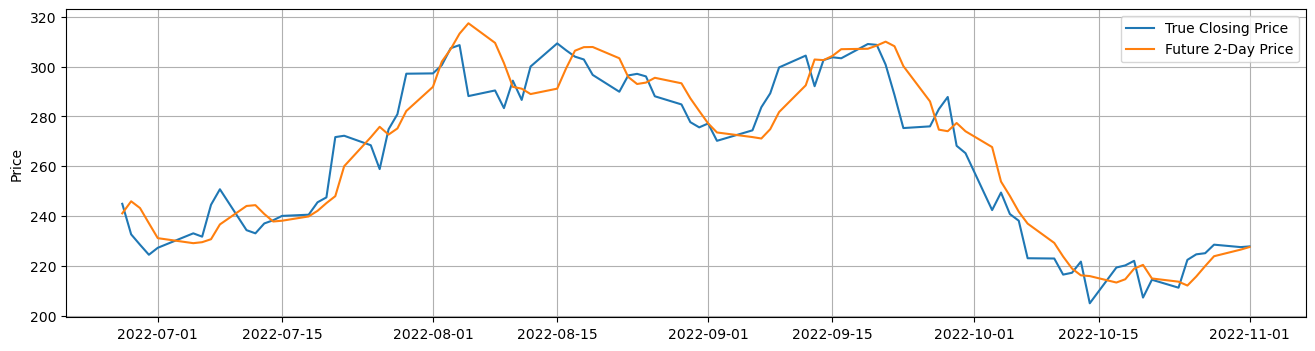

In [13]:
# transform the test data
test_ts = test_df[feature_encoder.classes_].to_numpy()
t = test_df.index
y_true = test_df["Close"].to_numpy()
sliding_prices = price_predictor.predict(test_ts)

# possible values for num_days_ahead are 1, 2 and 3
num_days_ahead = 2

# since the model predict the future prices up to 3 days, 
# here we only need the future 2-day price
y_pred = sliding_prices[:-1, num_days_ahead - 1]

# plot the result
plt.figure(figsize=(16, 4))
plt.plot(t, y_true, label="True Closing Price")
plt.plot(t, y_pred, label=f"Future {num_days_ahead}-Day Price")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()